# Module Dependency

In [1]:
%matplotlib inline

import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
# from skimage.restoration import wiener
from skimage.util import pad
from skimage.filters import laplace, sobel, median, gaussian
from scipy.signal import convolve2d
from skimage.color import rgb2gray

plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Read input and input_ori

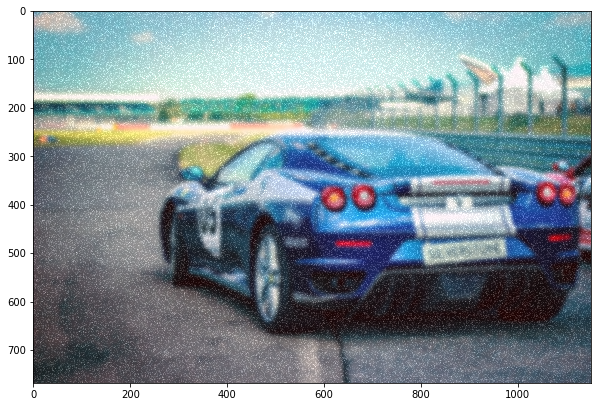

In [2]:
image = io.imread('./data/input3.bmp')
plt.imshow(image)

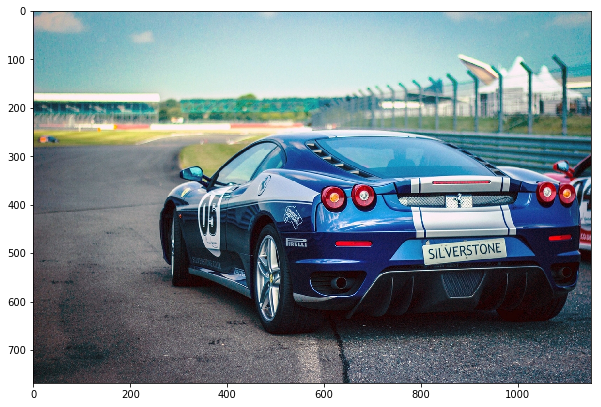

In [3]:
label = io.imread('./data/input3_ori.bmp')
plt.imshow(label)

# Change data type and show shape

In [4]:
image = image.astype('float64')
label = label.astype('float64')

# Pass gaussian filter to sigma analysis

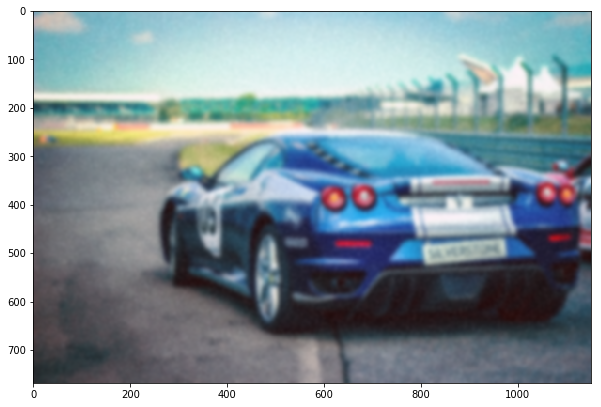

In [5]:
image_gau = image.copy()
for j in range(3):
    image_gau[:, :, j] = gaussian_filter(image[:, :, j], 3)
plt.imshow(image_gau.astype('uint8'))

# Algorithm for finding sigma

In [6]:
def sigma_gen(division, num):
    scale_factor = 2.0 ** (1.0/division)
    level_num = division * num + 1
    sigma = [1]
    for i in range(1, level_num):
        sigma.append(sigma[i-1] * scale_factor)
    return sigma
sigma_list = sigma_gen(10, 5)

In [7]:
error_plane = []
filtered = image.copy()
for sigma in sigma_list:
    for i in range(3):
        filtered[:, :, i] = gaussian_filter(image_gau[:, :, i], sigma)
    error_plane.append((sigma, np.linalg.norm(image_gau-filtered)))
error_plane

[(1, 510.71588007882684),
 (1.0717734625362931, 584.39633739285296),
 (1.1486983549970349, 668.65684419403567),
 (1.231144413344916, 764.40802328779171),
 (1.319507910772894, 873.17369944287032),
 (1.4142135623730947, 997.22328012434502),
 (1.5157165665103978, 1137.5279451803406),
 (1.6245047927124707, 1296.0475406859812),
 (1.7411011265922478, 1476.609443159427),
 (1.8660659830736144, 1679.0458911421426),
 (1.9999999999999996, 1908.5039911929116),
 (2.143546925072586, 2165.9953350987762),
 (2.2973967099940693, 2453.8567775885836),
 (2.4622888266898317, 2776.7944320665119),
 (2.6390158215457875, 3136.703406421896),
 (2.828427124746189, 3535.5998286648651),
 (3.0314331330207946, 3978.8555087972964),
 (3.2490095854249406, 4467.9300101414665),
 (3.4822022531844947, 5005.4942361458634),
 (3.7321319661472274, 5593.8823041167316),
 (3.9999999999999973, 6235.0018728137111),
 (4.28709385014517, 6930.2396313107656),
 (4.594793419988137, 7680.3729347092549),
 (4.924577653379662, 8486.98944536673

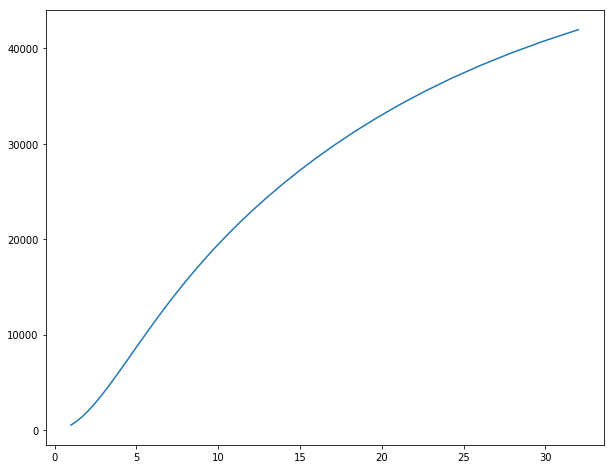

In [8]:
plt.plot(*zip(*error_plane))

In [9]:
max_diff = 0
max_sigma = 0
for i, error_pair in enumerate(error_plane[:-1]):
    sigma_1 = error_pair[0]
    sigma_2 = error_plane[i+1][0]
    error_1 = error_pair[1]
    error_2 = error_plane[i+1][1]
    diff = (error_2 - error_1)/(sigma_2 - sigma_1)
    if diff > max_diff:
        max_diff = diff
        max_sigma = sigma_1
print(max_sigma, max_diff)

4.594793419988137 2445.89167397


In [10]:
max_sigma = (max_sigma**2 - 9)**0.5
max_sigma

3.480248061901088

# Analysis of noise sigma

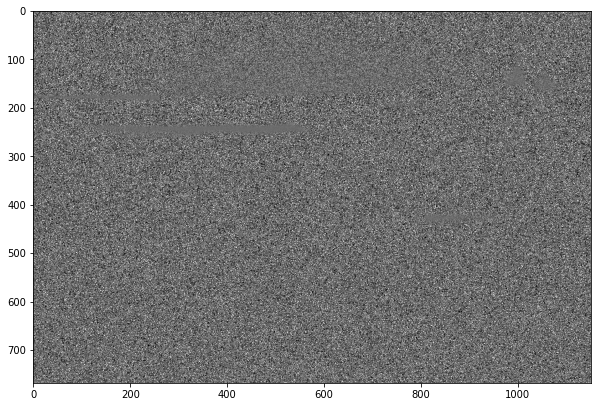

In [11]:
image_edge = rgb2gray(image.astype('uint8')) * 255
laplace = np.array([
    [1, -2, 1],
    [-2, 4, -2],
    [1, -2, 1]
])
image_edge = convolve2d(image_edge, laplace, mode='same', boundary='wrap')
# image_edge[ image_edge > 255] = 255
# image_edge[ image_edge < 0] = 0
plt.imshow(image_edge, cmap='gray')

In [12]:
sigma_n = (np.abs(image_edge).sum())/(6*(image_edge.shape[0]-2)*(image_edge.shape[1]-2))
sigma_n *= (np.pi/2)**0.5
sigma_n

14.792241060104718

# Wiener filter implementation

In [13]:
def wiener(image, psf, k):
    image_fft = np.fft.rfft2(image)
    psf_fft = np.fft.rfft2(psf, s=image.shape)
    restoration_fft = np.multiply((np.conj(psf_fft)/(np.square(np.abs(psf_fft)) + k)), image_fft)
    return np.fft.irfft2(restoration_fft, s=image.shape).astype('float64')

# Create Kernel

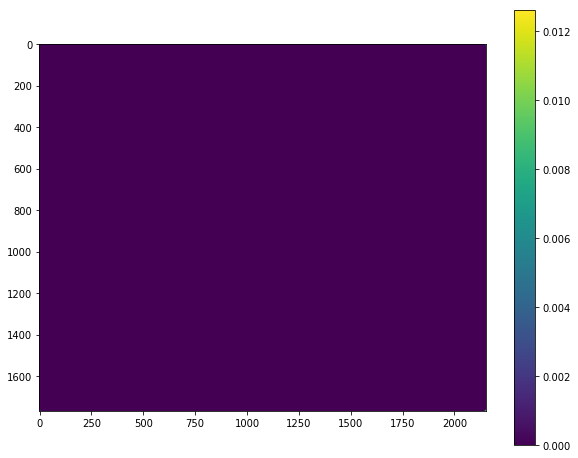

In [14]:
kernel = np.zeros((image.shape[0]+1000, image.shape[1]+1000), dtype='float64')
kernel[0][0] = 0.25
kernel[0][-1] = 0.25
kernel[-1][0] = 0.25
kernel[-1][-1] = 0.25
kernel = gaussian_filter(kernel, max_sigma)

plt.imshow(kernel)
plt.colorbar()
plt.show()

# Pad the image and use a trick

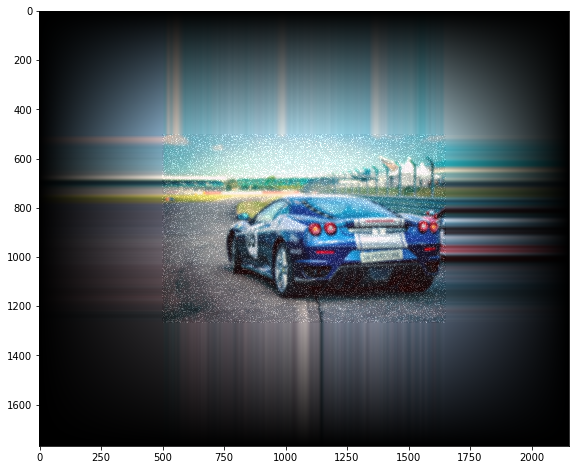

In [15]:
image_pad = np.zeros((image.shape[0]+1000, image.shape[1]+1000, 3))
for i in range(3):
    image_pad[:, :, i] = pad(image_gau[:, :, i], 500, mode='linear_ramp', end_values=0)
image_pad[500:-500, 500:-500, :] = image
plt.imshow(image_pad.astype('uint8'))

# Restoration and clip illegal data

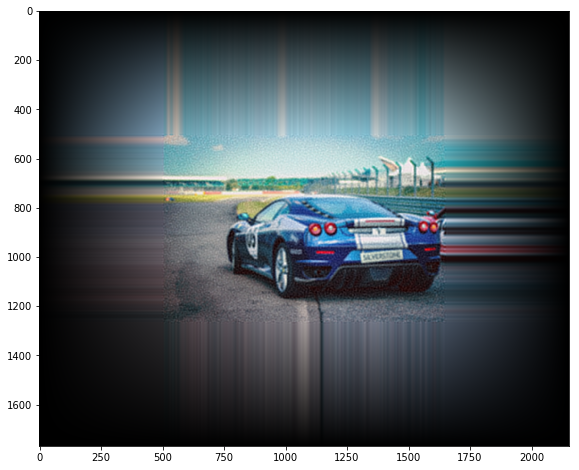

In [16]:
image_res = image_pad.copy()
for i in range(3):
    image_res[:, :, i] = wiener(image_pad[:, :, i], kernel, 0.06)
image_res[image_res > 255] = 255
image_res[image_res < 0] = 0
plt.imshow(image_res.astype('uint8'))

# Get original image size

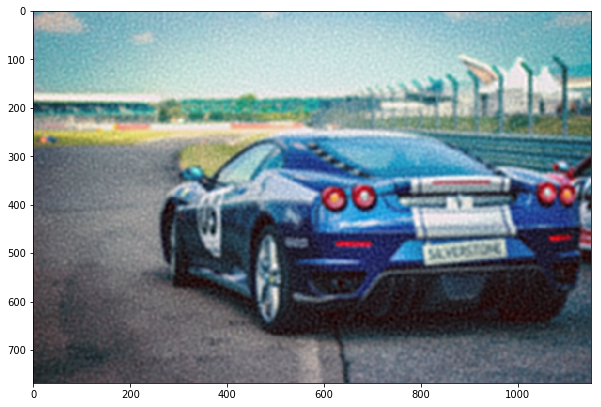

In [17]:
image_new = image.copy()
image_new = image_res[500:-500, 500:-500, :]
plt.imshow(image_new.astype('uint8'))

# PSNR function and calculate PSNR

In [18]:
def psnr(im1,im2):
    psnr = 0
    for i in range(im1.shape[2]):
        diff = np.abs(im1[:, :, i].astype('float64') - im2[:, :, i].astype('float64'))
        rmse = (np.square(diff).sum())/(im1.shape[0] * im1.shape[1])
        psnr += 10*np.log10((255**2)/rmse)
    return psnr

In [19]:
print('Initail PSNR: {}'.format(psnr(label, image)))
print('After restoration: {}'.format(psnr(label, image_new)))

Initail PSNR: 58.827829808452535
After restoration: 68.20514181918242


# Save output image

In [21]:
io.imsave('./data/output3.bmp' ,image_new.astype('uint8'))

# The codes below are used for report

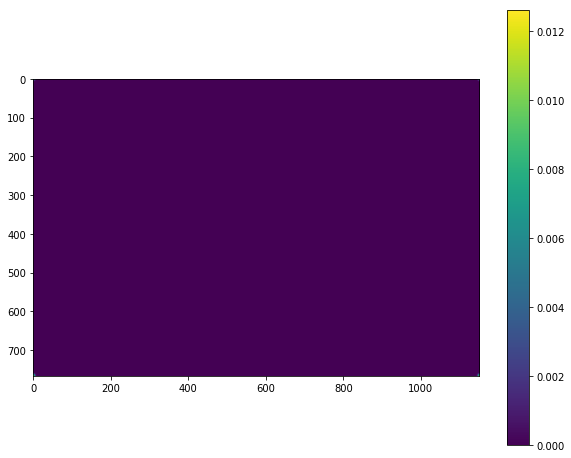

In [165]:
kernel = np.zeros((image.shape[0], image.shape[1]), dtype='float64')
kernel[0][0] = 0.25
kernel[0][-1] = 0.25
kernel[-1][0] = 0.25
kernel[-1][-1] = 0.25
kernel = gaussian_filter(kernel, max_sigma)

plt.imshow(kernel)
plt.colorbar()
plt.show()

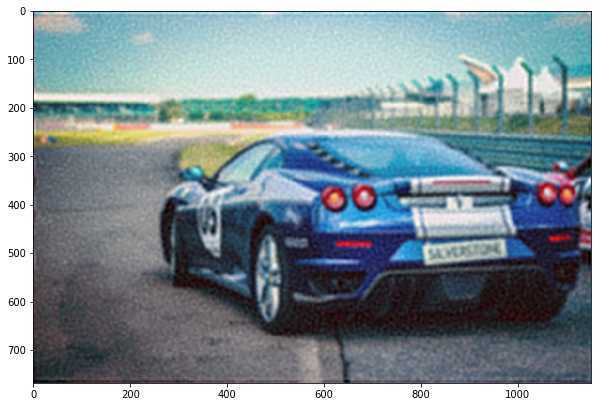

In [167]:
image_res = image.copy()
for i in range(3):
    image_res[:, :, i] = wiener(image[:, :, i], kernel, 0.06)
image_res[image_res > 255] = 255
image_res[image_res < 0] = 0
plt.imshow(image_res.astype('uint8'))

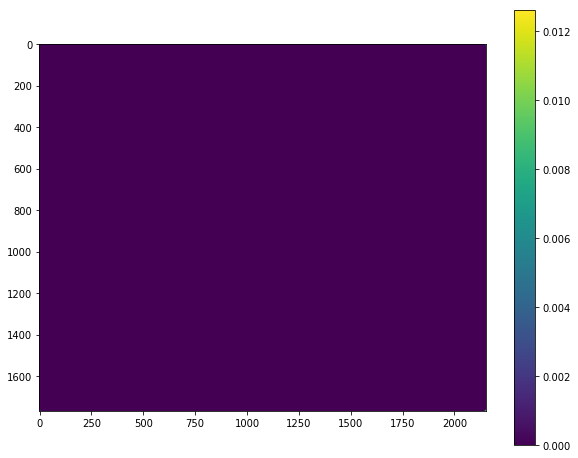

In [168]:
kernel = np.zeros((image.shape[0]+1000, image.shape[1]+1000), dtype='float64')
kernel[0][0] = 0.25
kernel[0][-1] = 0.25
kernel[-1][0] = 0.25
kernel[-1][-1] = 0.25
kernel = gaussian_filter(kernel, max_sigma)

plt.imshow(kernel)
plt.colorbar()
plt.show()

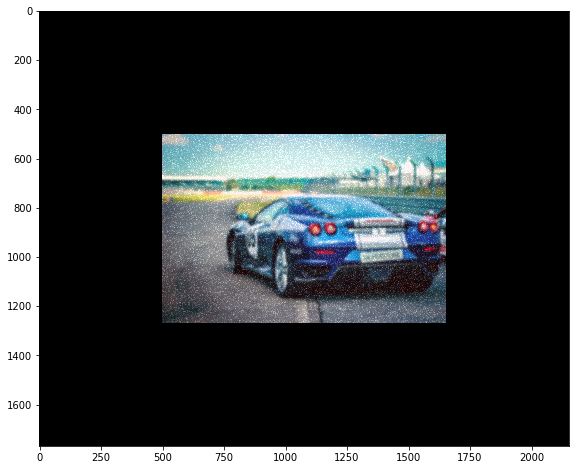

In [170]:
image_pad = np.zeros((image.shape[0]+1000, image.shape[1]+1000, 3))
for i in range(3):
    image_pad[:, :, i] = pad(image_gau[:, :, i], 500, mode='constant', constant_values=0)
image_pad[500:-500, 500:-500, :] = image
plt.imshow(image_pad.astype('uint8'))

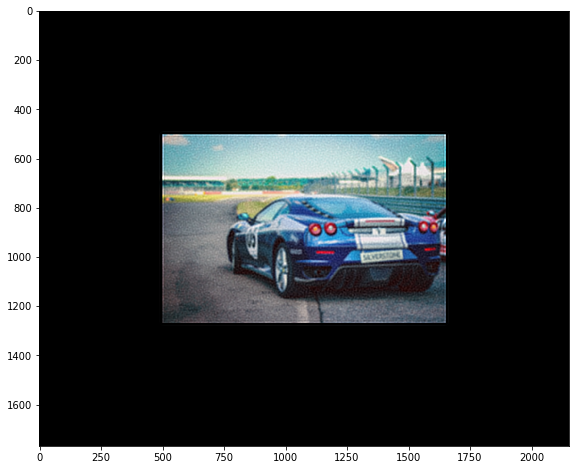

In [172]:
image_res = image_pad.copy()
for i in range(3):
    image_res[:, :, i] = wiener(image_pad[:, :, i], kernel, 0.06)
image_res[image_res > 255] = 255
image_res[image_res < 0] = 0
plt.imshow(image_res.astype('uint8'))

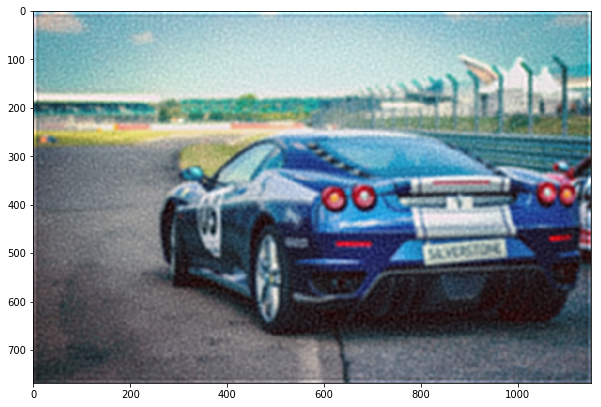

In [173]:
image_new = image.copy()
image_new = image_res[500:-500, 500:-500, :]
plt.imshow(image_new.astype('uint8'))